no

Dataset cargado exitosamente.

Preparando los datos...
Se eliminaron las filas sin valor en 'pm25_prediction'. Quedan 15384 filas.

Realizando limpieza final de NaNs en las features...
No se encontraron NaNs en las features. ¡Todo limpio!

Datos divididos cronológicamente:
  - 12307 filas para entrenamiento.
  - 3077 filas para prueba.

Entrenando el modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3635
[LightGBM] [Info] Number of data points in the train set: 12307, number of used features: 19
[LightGBM] [Info] Start training from score 18.249885
¡Modelo entrenado!

Realizando predicciones en el conjunto de prueba...

--- Resultados de la Evaluación ---
Error Absoluto Medio (MAE): 5.05
 -> En promedio, las predicciones del modelo se desvían en 5.05 µg/m³ del valor

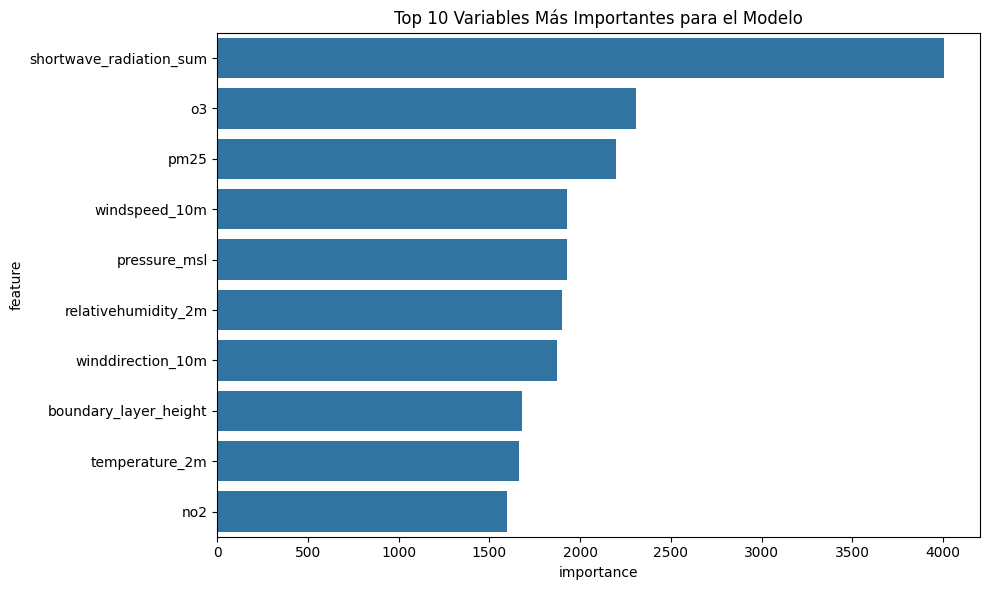

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Cargar el Dataset ---
archivo_datos = 'dataset_cdmx_con_prediccion.csv'

try:
    df = pd.read_csv(archivo_datos)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print("Dataset cargado exitosamente.")

    # --- 2. Preparar los Datos para el Modelo (Features y Target) ---
    print("\nPreparando los datos...")
    
    # --- 2A. Limpieza de Filas sin Target ---
    # La columna 'pm25_prediction' tiene NaN en las últimas 24 filas por diseño.
    # Eliminamos esas filas ya que no podemos entrenar ni predecir con ellas.
    df.dropna(subset=['pm25_prediction'], inplace=True)
    print(f"Se eliminaron las filas sin valor en 'pm25_prediction'. Quedan {len(df)} filas.")

    y = df['pm25_prediction']
    X = df.drop(columns=['pm25_prediction', 'timestamp'])
    
    # --- 2B. Limpieza Final de Features (LA CORRECCIÓN) ---
    # Nos aseguramos de que no quede ningún NaN en nuestras features (X)
    print("\nRealizando limpieza final de NaNs en las features...")
    if X.isnull().sum().sum() > 0:
        print("Se encontraron NaNs. Aplicando interpolación y relleno...")
        # Aplicamos la misma estrategia de interpolación que antes
        X = X.interpolate(method='linear', limit_direction='both')
        X.fillna(method='bfill', inplace=True)
        X.fillna(method='ffill', inplace=True)
        print("¡NaNs eliminados de X!")
    else:
        print("No se encontraron NaNs en las features. ¡Todo limpio!")

    # --- 3. División de Datos (CRÍTICO: División por Fecha) ---
    split_index = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
    X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]
    
    print(f"\nDatos divididos cronológicamente:")
    print(f"  - {len(X_train)} filas para entrenamiento.")
    print(f"  - {len(X_test)} filas para prueba.")

    # --- 4. Entrenamiento del Modelo LightGBM ---
    print("\nEntrenando el modelo LightGBM...")
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)
    model.fit(X_train, y_train)
    print("¡Modelo entrenado!")

    # --- 5. Predicción y Evaluación ---
    print("\nRealizando predicciones en el conjunto de prueba...")
    # Esta línea ahora funcionará porque X_test está limpio
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print("\n--- Resultados de la Evaluación ---")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f" -> En promedio, las predicciones del modelo se desvían en {mae:.2f} µg/m³ del valor real.")
    print(f"Coeficiente de Determinación (R²): {r2:.2f}")
    print(f" -> El modelo puede explicar el {r2*100:.0f}% de la variabilidad en la calidad del aire.")

    # --- 6. Importancia de las Características ---
    print("\n--- Variables Más Importantes ---")
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Top 10 Variables Más Importantes para el Modelo')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    print("Gráfico de importancia de variables guardado como 'feature_importance.png'")
    
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{archivo_datos}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

si

Dataset con lag features cargado. El dataset tiene 15360 filas y 25 columnas.

Usaremos 23 columnas como 'features' para predecir el 'target'.

Datos divididos cronológicamente:
  - 12288 filas para entrenamiento.
  - 3072 filas para prueba.

Entrenando el modelo LightGBM con los nuevos datos...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 12288, number of used features: 23
[LightGBM] [Info] Start training from score 18.209310
¡Modelo re-entrenado!

Realizando predicciones en el conjunto de prueba...

--- ¡Nuevos Resultados de la Evaluación! ---
Error Absoluto Medio (MAE): 4.91
Coeficiente de Determinación (R²): 0.21

--- Variables Más Importantes (con Lags) ---
Gráfico de importancia de variables guardado como 'feature_importance_con_lags.png'


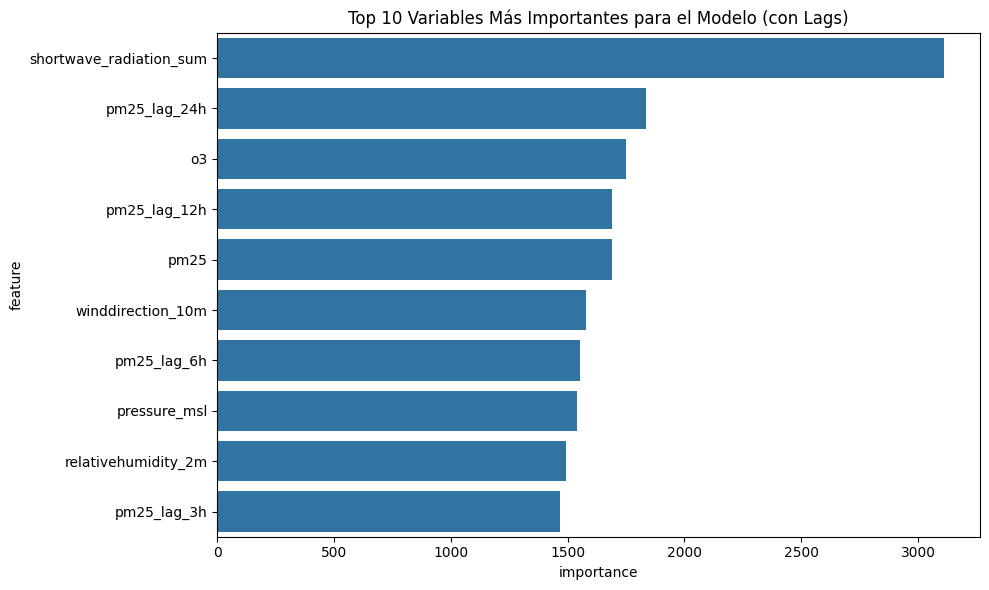

In [4]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Cargar el NUEVO Dataset con Lag Features ---
archivo_datos = 'dataset_cdmx_con_lags.csv'

try:
    df = pd.read_csv(archivo_datos)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"Dataset con lag features cargado. El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

    # --- 2. Preparar los Datos para el Modelo ---
    # La limpieza de NaNs ya no es necesaria porque el script anterior ya la hizo
    
    y = df['pm25_prediction']
    X = df.drop(columns=['pm25_prediction', 'timestamp'])
    
    print(f"\nUsaremos {X.shape[1]} columnas como 'features' para predecir el 'target'.")

    # --- 3. División de Datos Cronológica ---
    split_index = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
    X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]
    
    print(f"\nDatos divididos cronológicamente:")
    print(f"  - {len(X_train)} filas para entrenamiento.")
    print(f"  - {len(X_test)} filas para prueba.")

    # --- 4. Entrenamiento del Modelo LightGBM ---
    print("\nEntrenando el modelo LightGBM con los nuevos datos...")
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)
    model.fit(X_train, y_train)
    print("¡Modelo re-entrenado!")

    # --- 5. Predicción y Evaluación ---
    print("\nRealizando predicciones en el conjunto de prueba...")
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print("\n--- ¡Nuevos Resultados de la Evaluación! ---")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Coeficiente de Determinación (R²): {r2:.2f}")

    # --- 6. Importancia de las Características ---
    print("\n--- Variables Más Importantes (con Lags) ---")
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Top 10 Variables Más Importantes para el Modelo (con Lags)')
    plt.tight_layout()
    plt.savefig("feature_importance_con_lags.png")
    print("Gráfico de importancia de variables guardado como 'feature_importance_con_lags.png'")
    
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{archivo_datos}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

In [6]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# --- 1. Cargar el Dataset con Lag Features ---
archivo_datos = 'dataset_cdmx_con_lags.csv'

try:
    df = pd.read_csv(archivo_datos)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"Dataset '{archivo_datos}' cargado.")

    # --- 2. Preparar Datos (X y y) ---
    df.dropna(subset=['pm25_prediction'], inplace=True)
    y = df['pm25_prediction']
    X = df.drop(columns=['pm25_prediction', 'timestamp'])
    
    # Limpieza final por si acaso
    X = X.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

    # --- 3. División de Datos Cronológica ---
    split_index = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
    X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]
    
    print(f"Datos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

    # --- 4. Definir el Espacio de Búsqueda de Hiperparámetros ---
    param_grid = {
        'n_estimators': [500, 1000, 1500, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40, 50],
        'max_depth': [-1, 10, 15],
        'reg_alpha': [0.1, 0.5, 1.0],
        'reg_lambda': [0.1, 0.5, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    # --- 5. Configurar y Ejecutar la Búsqueda Aleatoria ---
    print("\nIniciando búsqueda de hiperparámetros... (Esto puede tardar varios minutos)")
    
    # Usamos TimeSeriesSplit para la validación cruzada, ¡es crucial para series de tiempo!
    tscv = TimeSeriesSplit(n_splits=5)
    
    lgbm = lgb.LGBMRegressor(random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_grid,
        n_iter=50,  # Número de combinaciones a probar
        scoring='neg_mean_absolute_error', # Métrica a optimizar (queremos minimizar MAE)
        cv=tscv,
        n_jobs=-1,  # Usar todos los procesadores disponibles
        verbose=1,
        random_state=42
    )

    # Ejecutar la búsqueda
    random_search.fit(X_train, y_train)

    print("\n¡Búsqueda finalizada!")
    print("--- Mejores Hiperparámetros Encontrados ---")
    print(random_search.best_params_)

    # --- 6. Re-entrenar el Modelo Final con los Mejores Parámetros ---
    print("\nRe-entrenando el modelo final con los parámetros óptimos...")
    
    best_model = random_search.best_estimator_
    
    # (El best_estimator_ ya está entrenado, pero es buena práctica re-entrenar en todos los datos de train)
    best_model.fit(X_train, y_train) 
    
    print("Realizando predicciones finales con el modelo optimizado...")
    predictions = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print("\n--- ¡RESULTADOS FINALES (MODELO OPTIMIZADO)! ---")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Coeficiente de Determinación (R²): {r2:.2f}")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{archivo_datos}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Dataset 'dataset_cdmx_con_lags.csv' cargado.
Datos divididos: 12288 para entrenar, 3072 para probar.

Iniciando búsqueda de hiperparámetros... (Esto puede tardar varios minutos)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\barbe\AppData\Local\Temp\ipykernel_24360\3519313597.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 12288, number of used features: 23
[LightGBM] [Info] Start training from score 18.209310

¡Búsqueda finalizada!
--- Mejores Hiperparámetros Encontrados ---
{'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 20, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.9}

Re-entrenando el modelo final con los parámetros óptimos...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 12288

creacion pkl

In [7]:
import pandas as pd
import lightgbm as lgb
import joblib # Importamos la librería para guardar el modelo

# --- 1. Cargar el Dataset con Lag Features ---
archivo_datos = 'dataset_cdmx_con_lags.csv'

try:
    df = pd.read_csv(archivo_datos)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"Dataset '{archivo_datos}' cargado para el entrenamiento final.")

    # --- 2. Preparar Datos (X y y) ---
    df.dropna(subset=['pm25_prediction'], inplace=True)
    y = df['pm25_prediction']
    X = df.drop(columns=['pm25_prediction', 'timestamp'])
    
    # Limpieza final
    X = X.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

    # --- 3. Entrenar el Modelo FINAL con los Mejores Parámetros en TODOS los datos ---
    # (Para el archivo final, es una práctica común entrenar con todos los datos disponibles)
    print("\nEntrenando el modelo final con los parámetros óptimos...")
    
    # Usamos los mejores parámetros que encontraste en la búsqueda anterior
    mejores_parametros = {
        'reg_lambda': 1.0, 
        'reg_alpha': 1.0, 
        'num_leaves': 20, 
        'n_estimators': 500, 
        'max_depth': 15, 
        'learning_rate': 0.01, 
        'colsample_bytree': 0.9
    }
    
    # Inicializamos y entrenamos el modelo final
    final_model = lgb.LGBMRegressor(**mejores_parametros, random_state=42)
    final_model.fit(X, y)
    
    print("¡Modelo final entrenado!")

    # --- 4. Guardar el Modelo en un Archivo .pkl ---
    nombre_archivo_modelo = 'modelo_pm25_predictor.pkl'
    print(f"\nGuardando el modelo en el archivo: {nombre_archivo_modelo}")
    
    joblib.dump(final_model, nombre_archivo_modelo)
    
    print(f"✅ ¡Éxito! El modelo ha sido guardado correctamente.")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{archivo_datos}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Dataset 'dataset_cdmx_con_lags.csv' cargado para el entrenamiento final.

Entrenando el modelo final con los parámetros óptimos...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4671
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 23
[LightGBM] [Info] Start training from score 17.065039


C:\Users\barbe\AppData\Local\Temp\ipykernel_24360\2823979478.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')


¡Modelo final entrenado!

Guardando el modelo en el archivo: modelo_pm25_predictor.pkl
✅ ¡Éxito! El modelo ha sido guardado correctamente.


no

Dataset final cargado. El dataset tiene 15337 filas y 37 columnas.

Usaremos 35 columnas como 'features' para predecir el 'target'.

Datos divididos cronológicamente:
  - 12269 filas para entrenamiento.
  - 3068 filas para prueba.

Entrenando el modelo final con todas las características...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7715
[LightGBM] [Info] Number of data points in the train set: 12269, number of used features: 35
[LightGBM] [Info] Start training from score 18.171652
¡Modelo final entrenado!

Realizando predicciones finales...

--- ¡RESULTADOS FINALES DE LA EVALUACIÓN! ---
Error Absoluto Medio (MAE): 4.98
Coeficiente de Determinación (R²): 0.18

--- Variables Más Importantes (Modelo Final) ---
Gráfico de importancia de variables guardado como 'feature_importance_final.png'


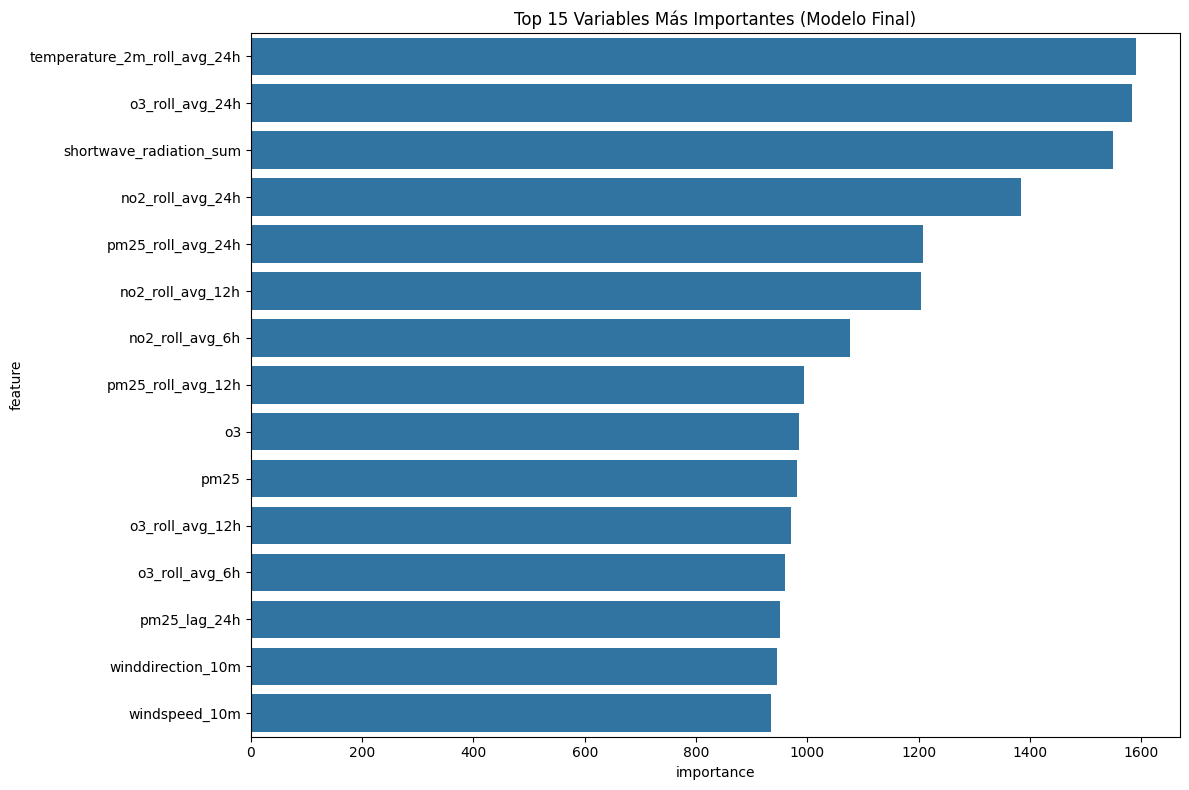

In [5]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Cargar el Dataset FINAL y más completo ---
archivo_datos = 'dataset_cdmx_lags_promedio.csv'

try:
    df = pd.read_csv(archivo_datos)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"Dataset final cargado. El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

    # --- 2. Preparar los Datos para el Modelo ---
    y = df['pm25_prediction']
    X = df.drop(columns=['pm25_prediction', 'timestamp'])
    
    print(f"\nUsaremos {X.shape[1]} columnas como 'features' para predecir el 'target'.")

    # --- 3. División de Datos Cronológica ---
    split_index = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
    X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]
    
    print(f"\nDatos divididos cronológicamente:")
    print(f"  - {len(X_train)} filas para entrenamiento.")
    print(f"  - {len(X_test)} filas para prueba.")

    # --- 4. Entrenamiento del Modelo LightGBM ---
    print("\nEntrenando el modelo final con todas las características...")
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)
    model.fit(X_train, y_train)
    print("¡Modelo final entrenado!")

    # --- 5. Predicción y Evaluación ---
    print("\nRealizando predicciones finales...")
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print("\n--- ¡RESULTADOS FINALES DE LA EVALUACIÓN! ---")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Coeficiente de Determinación (R²): {r2:.2f}")

    # --- 6. Importancia de las Características ---
    print("\n--- Variables Más Importantes (Modelo Final) ---")
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False).head(15) # Mostramos las 15 mejores
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Top 15 Variables Más Importantes (Modelo Final)')
    plt.tight_layout()
    plt.savefig("feature_importance_final.png")
    print("Gráfico de importancia de variables guardado como 'feature_importance_final.png'")
    
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{archivo_datos}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")